In [31]:
# Importing necessary libraries

import pandas as pd
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [32]:
# Reading dataframe from csv file
df_train = pd.read_csv("train.csv", delimiter=';')

In [33]:

# Taking all columns which are 'object' dtype and if contains ',' to convert it later into a float
numeric_columns_with_commas = [
    col for col in df_train.columns 
    if df_train[col].dtype == 'object' and df_train[col].str.contains(',').any()
]


# Converting those columns to floats and replace commas to a dots
for col in numeric_columns_with_commas:
    df_train[col] = pd.to_numeric(df_train[col].str.replace(',', '.'), errors='coerce')

# Check the data types again to see if the conversion was successful
#df_train.dtypes


In [34]:
# Managing datetime column

df_train['loan_date_created'] = pd.to_datetime(df_train['loan_date_created'], format='%d.%m.%Y')

# Extracting featues from this datetime column and create new columns 
df_train['year'] = df_train['loan_date_created'].dt.year
df_train['month'] = df_train['loan_date_created'].dt.month
df_train['day'] = df_train['loan_date_created'].dt.day
df_train['dayofweek'] = df_train['loan_date_created'].dt.dayofweek
df_train['hour'] = df_train['loan_date_created'].dt.hour

# Deleting this datetime column after extracting important features
df_train = df_train.drop(['loan_date_created'], axis = 1)

In [35]:
# Checking the missing values in columns
missing_values = df_train.isnull().sum()

# sorting the missing values in decreasing orded
missing_values = missing_values.sort_values(ascending=False)

In [36]:
# Calculating the percentage of missing data for each column
missing_percentage = df_train.isnull().mean() * 100

# When there is more than 50% missing data we drop the column
columns_to_drop = missing_percentage[missing_percentage > 50].index
df_train.drop(columns_to_drop, axis=1, inplace=True)

In [37]:
# Filling missing data in columns which are floats or integers with median 

for column in df_train.columns:
    # Checking if the column data type is integer or float
    if df_train[column].dtype == 'float64' or df_train[column].dtype == 'int64':
        # Calculating the median of this column
        median_value = df_train[column].median()
        # Fillin missing values in this column with median
        df_train[column].fillna(median_value, inplace=True)
    

In [38]:
# Ensuring the 'TARGET' column has no missing values and if yes, then we delete those rows
if df_train['TARGET'].isnull().any():
    df_train_dropped = df_train_dropped.dropna(subset=['TARGET'])
    

In [39]:
# Creating label encoder from sklearn library
label_encoder = preprocessing.LabelEncoder()

for column in df_train.columns:
    # Checking if the column data type is not float and integer to label encode only strings
    if df_train[column].dtype != 'float64' and df_train[column].dtype != 'int64':
        # Creating labels in columns which are not float and integers using label encoder
        df_train[column]= label_encoder.fit_transform(df_train[column])
        
        
        

In [40]:
for column in df_train.columns:
    # Checking if there are columns which are not floats or integer
    if df_train[column].dtype != 'float64' and df_train[column].dtype != 'int64':
        print(df_train[column])

In [41]:
# Cleaning test dataset using the same procedures as in testing dataset

df_test = pd.read_csv("test.csv", delimiter=';')

# Taking all columns which are 'object' dtype and if contains ',' to convert it later into a float
numeric_columns_with_commas = [
    col for col in df_test.columns 
    if df_test[col].dtype == 'object' and df_test[col].str.contains(',').any()
]


# Converting those columns to floats and replace commas to a dots
for col in numeric_columns_with_commas:
    df_test[col] = pd.to_numeric(df_test[col].str.replace(',', '.'), errors='coerce')
    

# Managing datetime column

df_test['loan_date_created'] = pd.to_datetime(df_test['loan_date_created'],  format='%d.%m.%Y')

# Extracting featues from this datetime column and create new columns 
df_test['year'] = df_test['loan_date_created'].dt.year
df_test['month'] = df_test['loan_date_created'].dt.month
df_test['day'] = df_test['loan_date_created'].dt.day
df_test['dayofweek'] = df_test['loan_date_created'].dt.dayofweek
df_test['hour'] = df_test['loan_date_created'].dt.hour

# Deleting this datetime column after extracting important features
df_test = df_test.drop(['loan_date_created'], axis = 1)

df_test

# Check the data types again to see if the conversion was successful
df_test.dtypes



# Calculating the percentage of missing data for each column
missing_percentage = df_test.isnull().mean() * 100

# When there is more than 50% missing data we drop the column
columns_to_drop = missing_percentage[missing_percentage > 50].index
df_test.drop(columns_to_drop, axis=1, inplace=True)


# Filling missing data in columns which are floats or integers with median 

for column in df_test.columns:
    # Checking if the column data type is integer or float
    if df_test[column].dtype == 'float64' or df_test[column].dtype == 'int64':
        # Calculating the median of this column
        median_value = df_test[column].median()
        # Fillin missing values in this column with median
        df_test[column].fillna(median_value, inplace=True)
        


    
    
    
# Creating label encoder from sklearn library
label_encoder = preprocessing.LabelEncoder()

for column in df_test.columns:
    # Checking if the column data type is not float and integer to label encode only strings
    if df_test[column].dtype != 'float64' and df_test[column].dtype != 'int64':
        # Creating labels in columns which are not float and integers using label encoder
        df_test[column]= label_encoder.fit_transform(df_test[column])
        
for column in df_test.columns:
    # Checking if there are columns which are not floats or integer
    if df_test[column].dtype != 'float64' and df_test[column].dtype != 'int64':
        print(df_test[column])    
    



/tmp/ipykernel_75118/4072036050.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv("test.csv", delimiter=';')


In [42]:
# Creating X dataframe which does not have label column and y dataframe which has only label column
X = df_train.drop('TARGET', axis=1)  # Features
y = df_train['TARGET']  # Labels

In [43]:
# Reducing dimensionality using PCA components
X_std = StandardScaler().fit_transform(X)

# Instantiate PCA object
pca = PCA(n_components=2) # Reduce data to 2 dimensions

# Fit and transform the data
X = pca.fit_transform(X_std)

In [44]:
# Spliting data on train and test sets to evaluate performance of the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

X_train

array([[-3.69197867, -1.75098121],
       [ 1.50900056, -1.89840203],
       [-0.48241742, -3.08902243],
       ...,
       [-5.15397   , -1.62829214],
       [-5.21474201, -2.52034208],
       [-3.57057645, -2.08508185]])

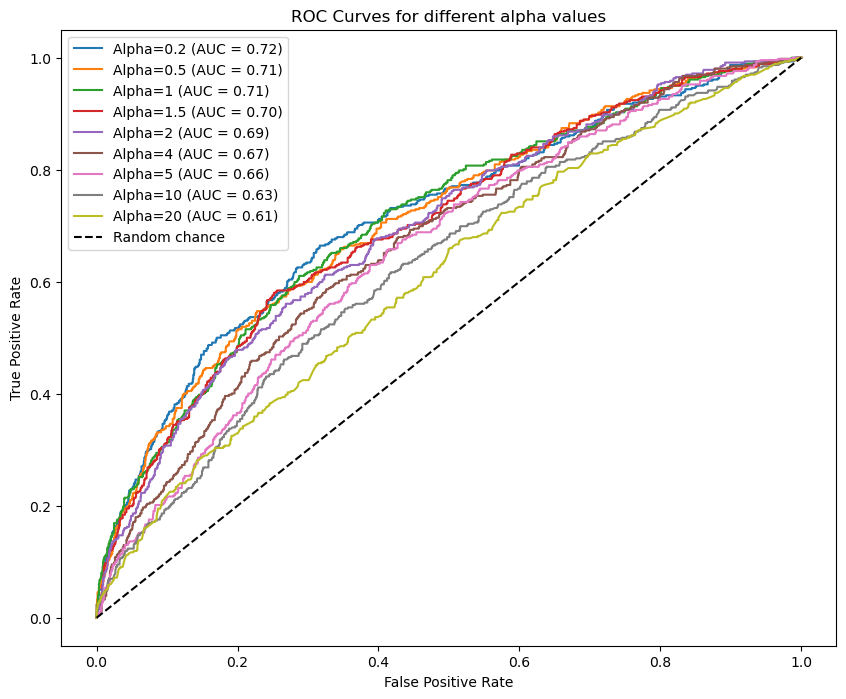

In [45]:
# Selected learning rate values which will be tested to check the model performance
alpha_values = [0.2, 0.5, 1, 1.5, 2, 4, 5, 10, 20]

# There will be stored performance of a model
model_performance = {}

for alpha in alpha_values:
    # Applying XGBoost model with some alpha value, applying random_state to see the same performance later
    model = XGBClassifier(eval_metric = 'logloss', reg_alpha = alpha, random_state = 50)
    
    # Fitting the model to training data
    model.fit(X_train, y_train)
    
    # Predicting probabilities on test data
    y_pred_proba = model.predict_proba(X_test)[:,1]
    

    # Calculating AUC score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Calculating ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Storing results to models_performance, to compare different learning rate values to choose the best model
    model_performance[alpha] = {"AUC": auc_score, "FPR": fpr, "TPR": tpr}
    
    
# PLOTTING ROC CURVE
plt.figure(figsize=(10, 8))
for alpha, performance in model_performance.items():
    plt.plot(performance['FPR'], performance['TPR'], label=f'Alpha={alpha} (AUC = {performance["AUC"]:.2f})')
    
# ploting random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title('ROC Curves for different alpha values')
plt.legend(loc='upper left')
plt.show()


In [46]:
# We choose alpha = 0.2 because the model which this learning rate had the best performance
# Applying XGBoost model with alpha value = 0.2
model = XGBClassifier(eval_metric = 'logloss', reg_alpha = 0.2, random_state = 50)

# Fitting the model to training data - learning model on training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=50, ...)

In [47]:
# Applying this model predictions to a test dataset

# scaling test dataset using the same dimension reduction as in train dataset
X_test = df_test
X_test_std = StandardScaler().fit_transform(X_test)


X_test_pca = pca.transform(X_test_std)


predictions = model.predict(X_test_pca)

predictions


array([0, 0, 1, ..., 0, 1, 0])

In [48]:
# Applying target column to a test dataframe using model predictions
df_test['TARGET'] = predictions

In [49]:
# Saving new dataset to a csv file
df_test.to_csv("df_test.csv")